# LGDI

This jupyter-notebook is used to show how row-based LGDI (can work better if missing value gap size is small) and col-based LGDI (can work better if missing value gap is large) work. These two methods are all based on Reshape Method 3. More details of the algorithms are introduced in our IEEE Sensor journal paper: "Data Imputation for Multivariate Time Series Sensor Data with Large Gaps of Missing Data"

In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import r2_score, mean_squared_error
import random


from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline


from datetime import datetime
from dateutil.parser import parse
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from scipy.special import boxcox, inv_boxcox
import util

# This is used to decide the K of K-fold cross validation
CV = 5
# decide the missing data for a matrix
HOLE_PERCENT = 0.3

# for boxcox transformation
# Sometimes data transformation can help improve the accuracy
LMBDA = 2
DATA_TRANSFORM = True

# -1 means use first available factor to reshape
# or you can mannualy decide the reshape factor
RESHAPE_FACTOR = -1
# RESHAPE_FACTOR = 10

# if ROW_BASED_RESHAPE = False, then this is col-based LGDI
# if ROW_BASED_RESHAPE = True, then this is row-based LGDI
ROW_BASED_RESHAPE = False

# defines which chunk of the CV to visualize
VISUALIZE_CHUNK = 1

# LGDI is for multivariate data imputation.
# this program checks accuracy for the variable with continous
# missing gap. COL_NAME = 'q_cms', so we check imputation accuracy
# for q_cms because we will create continous missing gap for
# q_cms only. Other variable will also have missing values
COL_NAME = 'q_cms'

# this is the Extreme Event Flag Column in Figure 4.
# this can be created with different extreme value detection algorithms
COL_THRESHOLD = 'Basic_Threshold'

# this is an input parameter for MICE Imputation function
MAX_ITER = 10

# this is the continous data gap percentage
TESTING_PERCENTAGE = 1/float(CV)

In [56]:
# In this example we demo how LGDI can be applied to MICE
# MICE can have different kernals

# KERNEL = DecisionTreeRegressor(max_features='sqrt')
# KERNEL = KNeighborsRegressor(n_neighbors=3)
# KERNEL = SVR(C=0.5, epsilon=0.25, gamma='scale')
# KERNEL = MLPRegressor(learning_rate='adaptive', max_iter=500)
KERNEL = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100)

In [57]:
# We have three sample datasets
# todo
# df_with_time = pd.read_csv("Data/wade.csv",sep=',')
# df_with_time = pd.read_csv("Data/Hungerford.csv",sep=',')
df_with_time = pd.read_csv("Data/Potash.csv",sep=',')

# we may have some missing values before we create holes and gaps
# the estimations of these missing values cannot be compared with ground truth
# so we just removed these records
# .reset_index() make sure index starting from 0
# this will insert the previous index as first col
df_no_nan = df_with_time.dropna().reset_index()


# In the sample data, the first two cols are index and timestamp
# the last col is threshold, we need to remove these three cols
df_no_nan_no_time = df_no_nan.iloc[:,2:-1]
df_no_nan_no_time_copy = df_no_nan_no_time.copy()

In [58]:
# index of all outliers
results = {'alarms':[], 'normal':[]}
results['alarms'] = df_no_nan.index[df_no_nan[COL_THRESHOLD]==1].tolist()
# create normal events index list
total_data_size = df_no_nan.shape[0]
results['normal'] = np.setdiff1d(range(total_data_size),results['alarms'])

# each cross validation data size 
cv_data_size = int(total_data_size/CV)

# this is original dataset with timestamps
original = df_with_time.dropna().reset_index()

In [59]:
r_2_list = []
mse_list = []
vis_prediction = []
vis_gap = []
x_index = []
for i in range(CV):
    print("currently dealing with loop:", i)
    
    df_no_nan_no_time_backup = df_no_nan_no_time_copy.copy()
    if DATA_TRANSFORM:
        # data tranformation
        df_no_nan_no_time_backup[COL_NAME] = boxcox(df_no_nan_no_time_backup[COL_NAME],LMBDA)
    
    # create holes for all variables
    util.make_holes_matrix(df_no_nan_no_time_backup,HOLE_PERCENT,COL_NAME)

    # start and end of continous missing value gap
    start_index = i*cv_data_size
    end_index = start_index + cv_data_size


    # create holes for normal and extreme events
    for index in range(start_index, end_index):
        df_no_nan_no_time_backup[COL_NAME].iloc[index] = np.nan


    # if one row has an extreme event, then treat this line as extreme event
    # if ROW_BASED_RESHAPE == False, this is Col-based LGDI
    # the returned qualified factors are just based on total number of rows in a file
    # the factor should be better selected based on autocorrelation values
    if ROW_BASED_RESHAPE == False:
        print('current df shape is:'+str(df_no_nan_no_time_backup.shape))
        # reshape
        reshape_df, factor = util.ccrm(df_no_nan_no_time_backup, RESHAPE_FACTOR)
        reshape_normal_row_index_list, reshape_extreme_row_index_list = util.convert_row_index_col_based_reshape(results['alarms'], factor, df_no_nan_no_time_backup.shape[0])
        if len(reshape_normal_row_index_list) != 0:
            df_normal = reshape_df.iloc[reshape_normal_row_index_list]
            df_extreme = reshape_df.iloc[reshape_extreme_row_index_list]

            imp_normal = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
            imp_extreme = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)

            array_filled_normal = imp_normal.fit_transform(df_normal)
            array_filled_extreme = imp_extreme.fit_transform(df_extreme)

            array_filled = util.combine_normal_extreme(reshape_df.shape[0], reshape_extreme_row_index_list, reshape_normal_row_index_list, array_filled_extreme, array_filled_normal, reshape_df.shape[0],reshape_df.shape[1])
        else:
            # when no normal events
            df_extreme = reshape_df.iloc[reshape_extreme_row_index_list]
            imp_extreme = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
            array_filled = imp_extreme.fit_transform(df_extreme)

        # reverse reshape
        df_tmp = pd.DataFrame(array_filled)
        original_n1 = df_no_nan_no_time_backup.shape[0]
        original_n2 = df_no_nan_no_time_backup.shape[1]
        original_df = util.ccrm_reverse(df_tmp, original_n1, original_n2)
        array_filled = original_df.to_numpy()
    # if ROW_BASED_RESHAPE == True, this is Row-based LGDI
    else:
        print('current df shape is:'+str(df_no_nan_no_time_backup.shape))
        # by default, the minimum factor will be used
        # it means the shape will be balanced (row and col number not too small)
        reshape_df, factor = util.row_based_reshape(df_no_nan_no_time_backup, RESHAPE_FACTOR)

        reshape_normal_row_index_list, reshape_extreme_row_index_list = util.convert_row_index_row_based_reshape(results['alarms'], factor, df_no_nan_no_time_backup.shape[0])

        df_normal = reshape_df.iloc[reshape_normal_row_index_list]
        df_extreme = reshape_df.iloc[reshape_extreme_row_index_list]

        imp_normal = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
        imp_extreme = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)

        array_filled_normal = imp_normal.fit_transform(df_normal)
        array_filled_extreme = imp_extreme.fit_transform(df_extreme)

        array_filled = util.combine_normal_extreme(reshape_df.shape[0], reshape_extreme_row_index_list, reshape_normal_row_index_list, array_filled_extreme, array_filled_normal, reshape_df.shape[0],reshape_df.shape[1])
        # # transpose to avoid multiple holes for the same row
        # array_filled = imp.fit_transform(reshape_df.T)
        # array_filled = imp.fit_transform(reshape_df)
        # reverse reshape
        df_tmp = pd.DataFrame(array_filled)
        original_n1 = df_no_nan_no_time_backup.shape[0]
        original_n2 = df_no_nan_no_time_backup.shape[1]

        # original_df = util.row_based_reshape_reverse(df_tmp.T, original_n1, original_n2)
        original_df = util.row_based_reshape_reverse(df_tmp, original_n1, original_n2)
        array_filled = original_df.to_numpy()


    # calculate accuracy between backup and df
    ground_truth = []
    prediction = []

    if DATA_TRANSFORM:
        # convert array to float
        array_filled = array_filled.astype(float)
        # back transformation
        # we may generate nan value
        array_filled[:,0] = np.nan_to_num(inv_boxcox(array_filled[:,0],LMBDA))
        # array_filled[:,0] = array_filled[:,0]*10

    for index in range(start_index, end_index):
        # rule 1: prediction should be above 0
        if array_filled[:,0][index]<0:
            prediction.append(0)
            array_filled[:,0][index] = 0
        else:
            prediction.append(array_filled[:,0][index])

        ground_truth.append(original[COL_NAME].iloc[index])


    tmp_r_2 = r2_score(ground_truth.copy(), prediction.copy())
    print("current R2 is", tmp_r_2)
    tmp_mse = mean_squared_error(ground_truth.copy(), prediction.copy())
    print("current mse is", tmp_mse)
    r_2_list.append(tmp_r_2)
    mse_list.append(tmp_mse)


    if i+1 == VISUALIZE_CHUNK:
        x_index = range(start_index, end_index)
        vis_prediction = array_filled[:,0].copy()
        vis_gap = df_no_nan_no_time_backup[COL_NAME].copy()

        
# calculate R2 value
avg_r2 = sum(r_2_list) / len(r_2_list)
print("average R^2 is: ", avg_r2)
print(r_2_list)
# calculate mse value
avg_mse = sum(mse_list) / len(mse_list)
print("average MSE is: ", avg_mse)
print(mse_list)


currently dealing with loop: 0
current df shape is:(3160, 11)
Qualified factors include: [1580, 790, 632, 395, 316, 158, 79, 40, 20, 10, 8, 5, 4, 2]
After reshape, the current shape is:(1580, 22)


/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.7081782128357743
current mse is 0.1891278340500847
currently dealing with loop: 1
current df shape is:(3160, 11)
Qualified factors include: [1580, 790, 632, 395, 316, 158, 79, 40, 20, 10, 8, 5, 4, 2]
After reshape, the current shape is:(1580, 22)


/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is -0.27486365674881874
current mse is 0.17222618829939745
currently dealing with loop: 2
current df shape is:(3160, 11)
Qualified factors include: [1580, 790, 632, 395, 316, 158, 79, 40, 20, 10, 8, 5, 4, 2]
After reshape, the current shape is:(1580, 22)


/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.7766987651793078
current mse is 0.08837063706344474
currently dealing with loop: 3
current df shape is:(3160, 11)
Qualified factors include: [1580, 790, 632, 395, 316, 158, 79, 40, 20, 10, 8, 5, 4, 2]
After reshape, the current shape is:(1580, 22)


/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.45947171509540663
current mse is 0.014675397896466729
currently dealing with loop: 4
current df shape is:(3160, 11)
Qualified factors include: [1580, 790, 632, 395, 316, 158, 79, 40, 20, 10, 8, 5, 4, 2]
After reshape, the current shape is:(1580, 22)


/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.17461902058064682
current mse is 0.011308569226516015
average R^2 is:  0.36882081138846334
[0.7081782128357743, -0.27486365674881874, 0.7766987651793078, 0.45947171509540663, 0.17461902058064682]
average MSE is:  0.09514172530718193
[0.1891278340500847, 0.17222618829939745, 0.08837063706344474, 0.014675397896466729, 0.011308569226516015]


/home/ruiwu1990/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


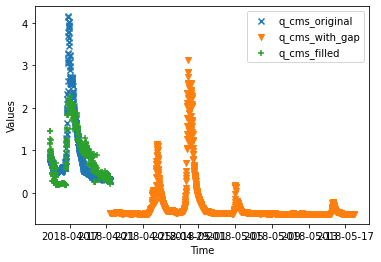

In [60]:
# This cell show the visualization results

x_time = util.get_time_stamp_array(original)
# original
y1 = original[COL_NAME]
# with gap
y1_gap = vis_gap

# filled with predictions
y1_filled = vis_prediction 

# +1 because the last one will be missing if not
original_gap_data = df_no_nan[COL_NAME].tolist()[x_index[0]:x_index[-1]+1]

# # vis
plt.scatter( x_time[x_index], original_gap_data, marker="x", label=COL_NAME+"_original")
plt.scatter( x_time, y1_gap, marker="v", label=COL_NAME+"_with_gap")
plt.scatter( x_time[x_index], y1_filled[x_index], marker="+", label=COL_NAME+"_filled")
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()